In [ ]:
import numpy as np
from src.jss_lite.jss_lite import jss_lite
t=np.empty((4,1),dtype=object)
import time
import os

In [10]:
# random choice on environments:
from multiprocessing import dummy
import numpy as np
from src.jss_lite.jss_lite import jss_lite
from wrapper.jssplight_wrapper import jssp_light_obs_wrapper_multi_instances
from wrapper.jssplight_wrapper import jssp_light_obs_wrapper_no_action_mask
t=np.empty((4,1),dtype=object)
import time
import os
from random import randrange
env= jssp_light_obs_wrapper_no_action_mask(jssp_light_obs_wrapper_multi_instances(instances_list=["/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/3x3x3/3x3_4_inst.json"],env_config="config"))

#env=jss_lite(instance_path="/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/3x3x3/3x3_4_inst.json")
state=env.get_state()
reward_list=[]
env.set_state(state)
token=False
max_reward=0
iteration=0
while iteration < 1:
    state=env.reset()
    #print(state)
    done=False
    i=0
    #print(state['obs'].shape)
    #for i in range(150):
    dummy_counter=0
    #print(env.get_legal_actions(state))
    while not done:
        i+=1
        legal_action=env.get_legal_actions()
        action=np.random.choice(len(legal_action), 1, p=(legal_action / legal_action.sum()))[0]
        #action=randrange(env.action_space.n)
        #print(action)
        if action < env.action_space.n/2:
    

            #print("before:")
            #env.render(start_count=1,x_bar="Job",y_bar="Machine")
            state, reward, done, info=env.step(action)
            if token==True:
                token=False
               # env.render()
            #print(state['obs'].shape)

        else:
            dummy_counter+=1
            #print("dummy action")
            #env.render()
            #print(action)
            #print(i)
            #print(env.get_legal_actions())
            #env.render()
            state, reward, done, info=env.step(action)  

            #print(state['obs'].shape)
            token=True
                #print("after:")
                #env.render(start_count=1,x_bar="Job",y_bar="Machine")
        #print(action)
        #tmp=(env.processed_and_max_time_job_matrix)
        #print(env.count_finished_tasks_machine_matrix)
        #print(env.production_list)
        #print(state)
        #env.render()
        if done==True:
            #print(f"finished! no legal actions possible after {i+1} steps")
            #print(env.timestemp_list)
            break
    #print(reward)
    if reward >max_reward:
        max_reward=reward
    reward_list.append(reward)
    #print(dummy_counter)
    #env.render(start_count=0,x_bar="Job",y_bar="Machine")
    iteration+=1
#print(max_reward)
#print(state)
env.render()
tmp_prod=env.env.env.production_list
print(tmp_prod)

[[(2, 1, 10, 18) (0, 2, 18, 23) (1, 2, 23, 27)]
 [(1, 0, 0, 5) (0, 0, 5, 7) (2, 0, 7, 10)]
 [(0, 1, 7, 11) (1, 1, 11, 14) (2, 2, 18, 27)]]


In [57]:
print(iteration)

14000


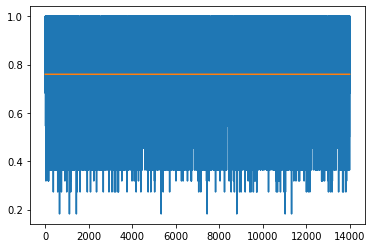

In [58]:
import matplotlib.pyplot as plt
import statistics as s
size_l=len(reward_list)
x=[i for i in range(0,size_l)]
plt.plot(x,reward_list)
meeee=s.mean(reward_list)
y=[meeee for i in range(0,size_l)]
plt.plot(x,y)

import json

with open("random_reward_14000sims_inst3_4.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(reward_list, f, indent=2) 

In [6]:
loading_instance="/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/15x15x15/15x15_4_inst.json"

def get_instance_name(string):
    return string.replace('/', ' ').split(' ')[-1].split('.')[-2]

print(get_instance_name(loading_instance))

15x15_4_inst


In [1]:
# load agent on environment:
from copy import deepcopy
from ray import rllib, tune
import ray
from ray.rllib.contrib.alpha_zero.core.alpha_zero_trainer import AlphaZeroTrainer
from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID
from ray.rllib.policy.policy_map import PolicyMap
from ray.rllib.evaluation.episode import MultiAgentEpisode
from ray.tune.registry import register_env
from ray.rllib.contrib.alpha_zero.models.custom_torch_models import DenseModel
from ray.rllib.contrib.alpha_zero.models.custom_torch_models import ConvNetModel

#from src.jss_lite.custom_torch_models import DenseModel_activation_relu as DenseModel

#from src.jss_lite.custom_torch_models import DenseModel
from ray.rllib.models.catalog import ModelCatalog

import gym
from src.jss_lite.jss_lite import jss_lite
from wrapper.jssplight_wrapper import jssp_light_obs_wrapper_multi_instances
loading_instance="/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/15x15x15/15x15_4_inst.json"
train_instances=[loading_instance]
#train_instances=["/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/15x15x15/15x15_"+str(i)+"_inst.json" for i in range(20)]
checkpoint_path="/Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoints/ima_15_15_no_act_10inner/15x15_2_inst/0/checkpoint-5"
checkpoint_path='/Users/felix/sciebo/masterarbeit/progra/model-based_rl/cluster_daten/one_environment/oneenvironment15/checkpoint-'
every_action_time=[]
train_rewards=[]
every_action=[]
for loading_instance in train_instances:

    ray.shutdown()
    ray.init()
    ModelCatalog.register_custom_model("dense_model", DenseModel)    
    def env_creator(config):
        env= jssp_light_obs_wrapper_multi_instances([loading_instance])
        return env

    tune.register_env('custom_jssp',env_creator)

    config_eval = {
        "framework": "torch",
        "disable_env_checking":True,
        "num_workers"       : 0,
        "rollout_fragment_length": 0,
        "train_batch_size"  : 0,
        "sgd_minibatch_size": 0,
        "lr"                : 0.0001,
        "explore"           :False,
        #"horizon"           : 600,
        #"soft_horizon"      : True,
        "num_sgd_iter"      : 0,
        #"horizon"           : 100,
        "mcts_config"       : {
            "puct_coefficient"   : 0,
            "num_simulations"    : 1,
            "temperature"        : 1,
            "dirichlet_epsilon"  : 0.20,
            "dirichlet_noise"    : 0.03,
            "argmax_tree_policy" : True,
            "add_dirichlet_noise": False,
        },
        "ranked_rewards"    : {
            "enable": True,
        },
        "model"             : {
            "custom_model": "dense_model",

        },
    }
    agent = AlphaZeroTrainer( config=config_eval, env='custom_jssp')
    for iteration in range(60,65):
        agent.load_checkpoint(checkpoint_path+str(iteration))
        import time
        length_list=[]
        reward_list=[]
        time_list=[]
        for _ in range(1):
            policy = agent.get_policy(DEFAULT_POLICY_ID)
            action_list=[]
            env = env_creator("config")
            obs = env.reset()
            episode = MultiAgentEpisode(
                PolicyMap(0,0),
                lambda _, __: DEFAULT_POLICY_ID,
                lambda: None,
                lambda _: None,
                0,
            )
            episode.user_data['initial_state'] = env.get_state()
            done = False
            while not done:
                begin_time=time.time()
                action, _, _ = policy.compute_single_action(obs, episode=episode)
                action_list.append(action)
                time_list.append(time.time()-begin_time)
                obs, reward, done, _ = env.step(action)
                episode.length += 1
            print(reward)
            #env.render()
        every_action_time.append(time_list)
        train_rewards.append(reward)
        every_action.append(action_list)

2022-12-17 16:27:01,139	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-12-17 16:27:01,144	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-12-17 16:27:27,050	INFO trainable.py:159 -- Trainable.setup took 25.918 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-12-17 16:27:27,085	WARNING deprecation.py:46 -- DeprecationWarning: `MultiAgentEpisode` has been deprecated. Use `ray.rllib.evaluation.episode.Episode` instead. This will raise an error in the future!
/Users/felix/miniconda3/envs/customjssp/lib/python3.10/site-packages/ray/rllib/contrib/alpha_zero/core/mcts.py:145: RuntimeWarning: invalid value encountered in true_divide
  tree_policy = tree_policy / np.max(


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
0
{}


KeyError: 0

In [97]:
obs=env.reset()
episode = MultiAgentEpisode(
    PolicyMap(0,0),
    lambda _, __: DEFAULT_POLICY_ID,
    lambda: None,
    lambda _: None,
    0,
)
episode.user_data['initial_state'] = env.get_state()


print(policy.compute_single_action(obs_batch=obs,episode=episode))

(0, [], {})


In [16]:
import json
#every_action2=[arr.tolist() for arr in every_action]
every_action2=every_action
every_action_time2=every_action_time
train_rewards2=train_rewards
#every_action_time2=[arr.tolist() for arr in every_action]
#train_rewards2=[arr.tolist() for arr in every_action]
print(type(every_action2[0][0]))
    

<class 'numpy.int64'>


In [21]:
every_action2 = [[float(i) for i in lst] for lst in every_action]
import json

with open("every_action.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(every_action2, f, indent=2) 

every_action_time2 = [[float(i) for i in lst] for lst in every_action_time]
import json

with open("every_action_time.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(every_action_time2, f, indent=2) 

train_rewards2 = [float(lst)  for lst in train_rewards]
import json

with open("train_rewards.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(train_rewards2, f, indent=2) 

import json

with open("file.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(score, f, indent=2) 



In [ ]:
from wrapper.jssplight_wrapper import jssp_light_obs_wrapper_multi_instances
from src.jss_lite.jss_lite import jss_lite
import numpy as np
#env=jss_lite(instance_path='/resources/jsp_instances/standard/la01.txt')
#print(env.observation_space)
#state=env.reset()

#legal_action_old=state['action_mask']
#instance_list=['resources/jsp_instances/standard/ft06.txt','resources/jsp_instances/standard/ft10.txt','resources/jsp_instances/standard/ft20.txt','resources/jsp_instances/standard/abz5.txt','resources/jsp_instances/standard/abz6.txt','resources/jsp_instances/standard/abz7.txt']
p1='/Users/felix/sciebo/masterarbeit/progra/model-based_rl'
p2='/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/3x3x3/3x3_1001_inst.json'
#env=jss_lite(instance_path=p1+'/resources/jsp_instances/standard/la01.txt')
env=jss_lite(instance_path=p2)


instance_list=['/resources/jsp_instances/standard/la01.txt','/resources/jsp_instances/standard/la02.txt','/resources/jsp_instances/standard/la03.txt','/resources/jsp_instances/standard/la04.txt']
instance_list=[p1 + s for s in instance_list]
#instance_list=['resources/jsp_instances/standard/ft06.txt']
#env=jssp_light_obs_wrapper_multi_instances(instances_list=instance_list)
reward=0
for _ in range(10):
    
    done=False
    state=env.reset()
    #print(state['obs'])
    i=0
    while not done:
        legal_action=state['action_mask']
        action=np.random.choice(len(legal_action), 1, p=(legal_action / legal_action.sum()))[0]
        print(action)

        state, reward, done, info=env.step(action)
        i+=1
        if done==True:
            #print(f"finished! no legal actions possible after {i} steps")
            break

    env.render(start_count=0,keep_grey=True)
#print(env.env.instance)
#print(reward)
#print(env.current_timestep)
#print(state['action_mask'])
#print(env.dummy_jobs)


In [ ]:
from difflib import restore


training_folder='/Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoints/checkpoints_tune/contrib/AlphaZero/contrib_AlphaZero_custom_jssp_f8da7_00000_0_2022-10-07_11-11-05'
for f in os.listdir(training_folder):
    if 'checkpoint' in f:
        restore_path=training_folder+'/'+f+'/checkpoint-'+str(int(f[-6:]))
        if os.path.exists(restore_path):
            print(restore_path)

In [ ]:
import os
#print(os.path.dirname(__file__))
p1='/Users/felix/sciebo/masterarbeit/progra/model-based_rl'
instance_list=['/resources/jsp_instances/standard/la01.txt','/resources/jsp_instances/standard/la02.txt','/resources/jsp_instances/standard/la03.txt','/resources/jsp_instances/standard/la04.txt','/resources/jsp_instances/standard/la05.txt']
instance_list=[p1 + s for s in instance_list]
print(instance_list)

In [ ]:
from ray import rllib, tune
from ray.rllib.contrib.alpha_zero.core.alpha_zero_trainer import AlphaZeroTrainer
from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID
from ray.rllib.policy.policy_map import PolicyMap
from ray.rllib.evaluation.episode import MultiAgentEpisode
from ray.tune.registry import register_env
#from ray.rllib.contrib.alpha_zero.models.custom_torch_models import DenseModel
from src.jss_lite.custom_torch_models import DenseModel_activation_relu as DenseModel
#from src.jss_lite.custom_torch_models import ConvNetModel
from ray.rllib.models.catalog import ModelCatalog
import gym
#from ray.rllib.contrib.alpha_zero.core.alpha_zero_trainer import AlphaZeroTrainer

from copy import deepcopy
import numpy as np
import pandas as pd
import os
import time
import ray
from src.jss_lite.jss_lite import jss_lite


ray.shutdown()
ModelCatalog.register_custom_model("dense_model", DenseModel)

#curr_dir=(os.path.dirname(__file__))
curr_dir='/Users/felix/sciebo/masterarbeit/progra/model-based_rl'
#instance_list=['/resources/jsp_instances/standard/la01.txt','/resources/jsp_instances/standard/la02.txt','/resources/jsp_instances/standard/la03.txt','/resources/jsp_instances/standard/la04.txt','/resources/jsp_instances/standard/la05.txt']
#instance_list=[curr_dir + s for s in instance_list]
#instance_path=curr_dir+'/resources/jsp_instances/standard/ft06.txt'
checkpoint_path='/training_checkpoints/checkpoints_tune'

from wrapper.jssplight_wrapper import jssp_light_obs_wrapper
from wrapper.jssplight_wrapper import jssp_light_obs_wrapper_multi_instances

def env_creator(config):
    #env = jssp_light_obs_wrapper(jss_lite(instance_path=instance_path))
    env=jssp_light_obs_wrapper_multi_instances(instances_list=instance_list)
    return env
def env_creator_single(instance):
    env=jssp_light_obs_wrapper_multi_instances(instances_list=instance)
    return env

def eval_env(agent,env):
    state=env.reset()
    policy = agent.get_policy(DEFAULT_POLICY_ID)
    episode = MultiAgentEpisode(
        PolicyMap(0,0),
        lambda _, __: DEFAULT_POLICY_ID,
        lambda: None,
        lambda _: None,
        0,
    )
    episode.user_data['initial_state'] = env.get_state()
    done = False
    episode_length=0
    start_time=time.time()
    while not done:
        action, _, _ = policy.compute_single_action(state, episode=episode)
        #print(episode_length)
        #print(f"action:{action}")
        #print(f"action_mask {state['action_mask']}")
        #print(f"action mask of action:{state['action_mask'][action]}")
        state, reward, done, _ = env.step(action)
        episode.length += 1
        episode_length += 1
    
    return time.time()-start_time, episode_length, reward

# use tune to register the custom environment for the ppo trainer
tune.register_env('custom_jssp',env_creator)
#tune.register_env('custom_jssp_single',env_creator())
config = {
    "framework": "torch",
    "disable_env_checking":True,
    "num_workers"       : 6,
    "rollout_fragment_length": 50,
    "train_batch_size"  : 500,
    "sgd_minibatch_size": 64,
    "lr"                : 0.0001,
    #"explore"           :False,
    #"horizon"           : 600,
    #"soft_horizon"      : True,
    "num_sgd_iter"      : 1,
    #"horizon"           : 100,
    "mcts_config"       : {
        "puct_coefficient"   : 1.5,
        "num_simulations"    : 50,
        "temperature"        : 1.5,
        "dirichlet_epsilon"  : 0.20,
        "dirichlet_noise"    : 0.03,
        "argmax_tree_policy" : False,
        "add_dirichlet_noise": False,
    },
    "ranked_rewards"    : {
        "enable": True,
    },
    "model"             : {
        "custom_model": "dense_model",

    },
}



agent = AlphaZeroTrainer( config=config, env='custom_jssp')
#if restore_agent:
#restore_path='training_checkpoints/checkpoints_az_jsslite/checkpoint-5'
training_folder='/Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoints/contrib_AlphaZero_custom_jssp_50160_00000_0_2022-10-17_18-46-57'
#training_folder='/home/fs608798/masterarbeit/model-based_rl/training_checkpoints/checkpoints_tune/contrib/AlphaZero/contrib_AlphaZero_custom_jssp_50160_00000_0_2022-10-17_18-46-57'
nr_checkpoints=0
for f in os.listdir(training_folder):
    if 'checkpoint' in f:
        nr_checkpoints+=1
eval_sheet={}
run=0
for f in os.listdir(training_folder):
    if 'checkpoint' in f:
        restore_path=training_folder+'/'+f+'/checkpoint-'+str(int(f[-6:]))
        if os.path.exists(restore_path):
            print(f)

            agent.load_checkpoint(restore_path)
            print("agent loaded")
            # here comes the evaluation:
            for instance in instance_list:
                print(instance)
                eval_sheet[str(f[-6:]),instance]=eval_env(agent,jssp_light_obs_wrapper_multi_instances(instances_list=[instance]))
            run+=1
            print(f"run: {run} of {nr_checkpoints} evaluated")
            df=pd.DataFrame.from_dict(eval_sheet)
            df.to_csv('eval.csv')

# generate csv    
df=pd.DataFrame.from_dict(eval_sheet)
df.to_csv('eval.csv')

In [ ]:
df=pd.DataFrame.from_dict(eval_sheet)
df.to_csv('eval.csv')

In [11]:
import pandas as pd
df=pd.read_csv('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/eval_3_multi_inst_10_check.csv')
print(df)

          Unnamed: 0  \
0       train_reward   
1  every_action_time   
2       every_action   
3              outer   
4          iteration   

  /Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoints/ima_3_3_no_act_10inner/3x3_0_inst/0/checkpoint-1  \
0                                  0.962962962962963                                                                             
1  [0.10071015357971191, 0.016278982162475586, 0....                                                                             
2                        [2, 1, 1, 2, 0, 1, 2, 0, 0]                                                                             
3                                                  0                                                                             
4                                                  1                                                                             

  /Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoi

In [ ]:
x=[1,2,3,4,5]
y=[2,3,4,5,6,7]
z=x+y
print(z)

In [ ]:
import numpy as np
arr=np.full((4,2),5)
arr[:,1]=np.full((4),3)

print(arr)
indi=(1,0)

mask=[1, 0, 1, 0, 0, 1]
mask_2=(np.transpose(np.reshape(mask,(2,int(len(mask)/2)))))
si=mask_2.shape[0]
#arr[:,:]=mask_2

arr=np.pad(arr,[0,0],mode='constant')
print(arr)
print(mask)
#print(arr[indi])
arr[0:si,:2]=mask_2
print(arr)


In [5]:
# test to synchronize the workers:
from ray import rllib, tune
from ray.rllib.contrib.alpha_zero.core.alpha_zero_trainer import AlphaZeroTrainer
from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID
from ray.rllib.policy.policy_map import PolicyMap
from ray.rllib.evaluation.episode import MultiAgentEpisode
from ray.tune.registry import register_env
from ray.rllib.contrib.alpha_zero.models.custom_torch_models import DenseModel
from src.jss_lite.custom_torch_models import ConvNetModel

#from src.jss_lite.custom_torch_models import DenseModel_activation_relu as DenseModel

#from src.jss_lite.custom_torch_models import DenseModel
from ray.rllib.models.catalog import ModelCatalog
#from src.jss_lite.custom_torch_models import DenseModel_activation_relu as DenseModel
#from src.jss_lite.custom_torch_models import ConvNetModel
import gym
#from ray.rllib.contrib.alpha_zero.core.alpha_zero_trainer import AlphaZeroTrainer

from copy import deepcopy
import numpy as np
import pandas as pd
import os
import time
import ray
from src.jss_lite.jss_lite import jss_lite
from wrapper.jssplight_wrapper import jssp_light_obs_wrapper_multi_instances
from wrapper.jssplight_wrapper import Tensor_Wrapper

ray.shutdown()
ModelCatalog.register_custom_model("dense_model", DenseModel)
ModelCatalog.register_custom_model("conv_net_model", ConvNetModel)

curr_dir='/Users/felix/sciebo/masterarbeit/progra/model-based_rl'

loading_instance="/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/3x3x3/3x3_7_inst.json"
loading_list=["/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/3x3x3/3x3_7_inst.json","/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/3x3x3/3x3_8_inst.json"]
num_inst=str(15)
instances_names='ima_'+num_inst+'_'+num_inst+'_no_act_10inner'
ima_inst_train=[]
ima_inst_test=[]

for i in range(0,20):
    ima_inst_train.append(curr_dir+'/resources/jsp_instances/ima/'+num_inst+'x'+num_inst+'x'+num_inst+'/'+num_inst+'x'+num_inst+'_'+str(i)+'_inst.json')
for i in range(21,30):
    ima_inst_test.append(curr_dir+'/resources/jsp_instances/ima/'+num_inst+'x'+num_inst+'x'+num_inst+'/'+num_inst+'x'+num_inst+'_'+str(i)+'_inst.json')


ray.shutdown()
ray.init()
ModelCatalog.register_custom_model("dense_model", DenseModel)
ModelCatalog.register_custom_model("conv_net_model", ConvNetModel)

def env_creator_variable_instance(config,env_name):
    return jssp_light_obs_wrapper_multi_instances([env_name])
def env_creator(config):
    env= jssp_light_obs_wrapper_multi_instances([loading_instance])
    return env


def env_creator_random_instance(config_random):
    #env= jssp_light_obs_wrapper_multi_instances(instances_list=[ima_inst_train[4]],env_config=config_random)
    env= Tensor_Wrapper(jssp_light_obs_wrapper_multi_instances(instances_list=[ima_inst_train[4]],env_config=config_random))
    return env

env=env_creator_random_instance('config')
tune.register_env('custom_jssp',lambda config: env_creator_random_instance(config))

config_eval = {
    "framework": "torch",
    "disable_env_checking":True,
    "num_workers"       : 0,
    "rollout_fragment_length": 50,
    "train_batch_size"  : 50,
    "sgd_minibatch_size": 1,
    "lr"                : 0.0001,
    "explore"           :False,
    #"horizon"           : 600,
    #"soft_horizon"      : True,
    "num_sgd_iter"      : 1,
    #"horizon"           : 100,
    "mcts_config"       : {
        "puct_coefficient"   : 1.5,
        "num_simulations"    : 100,
        "temperature"        : 1,
        "dirichlet_epsilon"  : 0.20,
        "dirichlet_noise"    : 0.03,
        "argmax_tree_policy" : False,
        "add_dirichlet_noise": False,
    },
    "ranked_rewards"    : {
        "enable": True,
    },
    "model"             : {
        "custom_model": "conv_net_model",
        "custom_model_config":{
         "in_channels":1,#env.observation_space['obs'].shape[0],
        "feature_dim":120,
        }
    }

   # "internal_training_counter":1,
    #"env_config": {"iterations":config_eval["internal_training_counter"]},
}
s_path='/Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoints/alpha_zero_conv_net/'+num_inst
if not os.path.exists(s_path):
    os.mkdir(s_path)
agent = AlphaZeroTrainer( config=config_eval, env='custom_jssp')
for _ in range(200):
    print(f"episode: {_}")
    #pass
    agent.train()
    #print(agent.config['internal_training_counter'])
    agent.save_checkpoint(s_path)

2022-12-27 12:49:04,489	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-12-27 12:49:04,506	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-12-27 12:49:45,563	INFO trainable.py:159 -- Trainable.setup took 41.076 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


episode: 0
episode: 1
episode: 2
episode: 3
episode: 4
episode: 5
episode: 6
episode: 7
episode: 8
episode: 9
episode: 10
episode: 11
episode: 12
episode: 13
episode: 14
episode: 15
episode: 16
episode: 17
episode: 18
episode: 19
episode: 20
episode: 21
episode: 22
episode: 23
episode: 24
episode: 25
episode: 26
episode: 27
episode: 28
episode: 29
episode: 30
episode: 31
episode: 32
episode: 33
episode: 34
episode: 35
episode: 36
episode: 37
episode: 38
episode: 39
episode: 40
episode: 41
episode: 42
episode: 43
episode: 44
episode: 45
episode: 46
episode: 47
episode: 48
episode: 49
episode: 50
episode: 51
episode: 52
episode: 53
episode: 54
episode: 55


KeyboardInterrupt: 

In [10]:
x=[[[1.0000, 0.0000, 0.0000, 0.1818, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.7273, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.8182, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.2727, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.9091, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.1818, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]
print(len(x))

1


In [3]:
obs=env.reset()



state=env.get_state()
print('state')
print(state)
obs=env.set_state(state)
print(obs)
#env.reset()

state
[<src.jss_lite.jss_lite.jss_lite object at 0x7fc43eddbdf0>, 35, 10]
{'obs': array([[1.    , 0.    , 0.    , 0.2727, 0.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , 0.2727, 0.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , 0.6364, 0.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , 0.4545, 0.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , 0.9091, 0.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , 0.7273, 0.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , 0.6364, 0.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , 0.3636, 0.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , 0.6364, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [

In [6]:
import torch
x={}
x['obs']=np.array([1.    , 0.    , 0.    , 0.2727, 0.    , 0.    , 0.    , 1.    ,
       0.    , 0.    , 0.2727, 0.    , 0.    , 0.    , 1.    , 0.    ,
       0.    , 1.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    ,
       0.6364, 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.4545,
       0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.9091, 0.    ,
       0.    , 0.    , 1.    , 0.    , 0.    , 0.7273, 0.    , 0.    ,
       0.    , 1.    , 0.    , 0.    , 0.6364, 0.    , 0.    , 0.    ,
       1.    , 0.    , 0.    , 0.3636, 0.    , 0.    , 0.    , 1.    ,
       0.    , 0.    , 0.6364, 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    ])
x['obs']=torch.from_numpy(x['obs']).view(15, 7)
print(x)

{'obs': tensor([[1.0000, 0.0000, 0.0000, 0.2727, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.2727, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.6364, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.4545, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.9091, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.7273, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.6364, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.3636, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.6364, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
 

In [9]:
from ray.rllib.agents.ppo import PPOTrainer
from ray import tune
import gym
from src.jss_lite.jss_lite import jss_lite
from wrapper.jssplight_wrapper import jssp_light_obs_wrapper_multi_instances
from wrapper.jssplight_wrapper import jssp_light_obs_wrapper_no_action_mask
from ray import tune
import os

train_agent=True

curr_dir='/Users/felix/sciebo/masterarbeit/progra/model-based_rl'
#curr_dir=(os.path.dirname(__file__))

num_inst=str(15)
instances_names='ima_'+num_inst+'_'+num_inst+'_ppo'
ima_inst_train=[]
ima_inst_test=[]

for i in range(0,20):
    ima_inst_train.append(curr_dir+'/resources/jsp_instances/ima/'+num_inst+'x'+num_inst+'x'+num_inst+'/'+num_inst+'x'+num_inst+'_'+str(i)+'_inst.json')
for i in range(21,30):
    ima_inst_test.append(curr_dir+'/resources/jsp_instances/ima/'+num_inst+'x'+num_inst+'x'+num_inst+'/'+num_inst+'x'+num_inst+'_'+str(i)+'_inst.json')


def env_creator_random_instance(config_random):
    #env= jssp_light_obs_wrapper_multi_instances(instances_list=[loading_instance],env_config=config)
    env= jssp_light_obs_wrapper_no_action_mask(jssp_light_obs_wrapper_multi_instances(instances_list=[ima_inst_train[4]],env_config=config_random))
    return env


tune.register_env('custom_jssp',lambda config: env_creator_random_instance(config))


restore_agent= False
num_episodes = 1000
#restore_path= 'training_checkpoints/checkpoints_az_jsslite/checkpoint-6'

config = {
    # Environment (RLlib understands openAI gym registered strings).
    #"env": "CartPole-v1",
    "env": "custom_jssp",
    # Use 2 environment workers (aka "rollout workers") that parallelly
    # collect samples from their own environment clone(s).
    "num_workers": 1,
    # Change this to "framework: torch", if you are using PyTorch.
    # Also, use "framework: tf2" for tf2.x eager execution.
    "framework": "tf",
    # Tweak the default model provided automatically by RLlib,
    # given the environment's observation- and action spaces.
    #"horizon":1000,
    "evaluation_duration":10,
    "model": {
        "fcnet_hiddens": [256, 256],
        "fcnet_activation": "relu",
    },
    # Set up a separate evaluation worker set for the
    # `trainer.evaluate()` call after training (see below).
    "evaluation_num_workers": 0,
    # Only for evaluation runs, render the env.
    "evaluation_config": {
        "render_env": False,
    },
    
}

trainer = PPOTrainer(config=config)

episode_reward = 0
env = env_creator_random_instance("config")


(RolloutWorker pid=43111) 2022-12-19 21:22:08,133	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-12-19 21:22:10,708	INFO trainable.py:159 -- Trainable.setup took 12.550 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


In [15]:
import numpy as np
reward_list=[]
for i in range(1,190):
    trainer.load_checkpoint('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/training_checkpoints/oneenvironmentima_15_15_ppo/checkpoint-'+str(i))

    done = False
    obs = env.reset()
    policy = trainer.get_policy()
    episode_reward=0
    iterations=0
    while not done:
        action, _, info = policy.compute_single_action(obs)
        logits = info['action_dist_inputs']
        action_mask = env.get_legal_actions().astype(np.float32)
        action_mask[action_mask==0] = - np.inf
        probs=np.multiply(logits,action_mask)
        probs[probs==np.inf]=-np.inf
        best_action_id = probs.argmax()  # deterministic
        highest_prob=probs.max()
        #print(f"action: {action}")
        obs, reward, done, info = env.step(best_action_id)
        episode_reward += reward
        #env.render(mode="human")
        iterations += 1
    #env.render()
    env.close()
    #print(episode_reward)
    reward_list.append(episode_reward)
    #print(iterations)



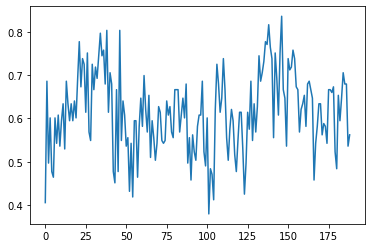

In [16]:
import matplotlib.pyplot as plt
plt.plot(reward_list)

In [23]:
# Import libraries
curr_dir='/Users/felix/sciebo/masterarbeit/progra/model-based_rl'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import json
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        } 
font_2 = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }
import math
import plotly.express as px
import pandas as pd
from datetime import datetime, timedelta
def json_render(path,x_bar="Machine",y_bar="Job",start_count=0,keep_grey=False):
    with open(path) as f:
        instance_dict = json.load(f)
    production_list=np.empty((int(instance_dict['n_resources']),int(instance_dict['n_jobs']*int(instance_dict['n_jobs'])/int(instance_dict['n_resources']))),dtype=object)
    def find_task(job,mach):
        return instance_dict['jssp_instance']['machines'][int(job)].index(int(mach))
    production_list_counter=np.zeros(int(instance_dict['n_resources']))    
    for i in range(instance_dict['n_jobs']*instance_dict['n_ops_per_job']):
        tup=(instance_dict['optimal_gantt_data'][str(i)]['Job_num'],find_task(instance_dict['optimal_gantt_data'][str(i)]['Job_num'],instance_dict['optimal_gantt_data'][str(i)]['Mach_num']),instance_dict['optimal_gantt_data'][str(i)]['Start_time'],int(instance_dict['optimal_gantt_data'][str(i)]['Start_time'])+int(instance_dict['optimal_gantt_data'][str(i)]['Job_time']))
        
        production_list[int(instance_dict['optimal_gantt_data'][str(i)]['Mach_num']),int(production_list_counter[int(instance_dict['optimal_gantt_data'][str(i)]['Mach_num'])])]=tup
        production_list_counter[int(instance_dict['optimal_gantt_data'][str(i)]['Mach_num'])]+=1
    n_machines=len(production_list)
    # is not time critical function. so O(n^2) is no problem; todo:make more pretty
    def production_to_dict(input,i,j):
        return(dict(Job=f"job_{str(input[0]+start_count).zfill(max_len)}", Start=dt + timedelta(seconds=int(input[2]+start_count)),Finish=dt + timedelta(seconds=int(input[3])),Machine=f"machine_{str(i+start_count).zfill(max_len)}"))
    dt = datetime(2022, 1, 1, 0, 0, 0)
    #stores quatuple(job,task,start_time,finish_time) 
    liste=[]
    max_len=len(str(max(production_list.shape[0]-1+start_count,production_list.shape[1]-1+start_count)))
    for i in range(production_list.shape[0]):
        for j in range(production_list.shape[1]):
            if production_list[i,j] is not None:
                liste.append(production_to_dict(production_list[i,j],i,j))
    df_render=pd.DataFrame(liste)
    if df_render.empty:
        # do not rise an error; production plan is empty and could be filled
        print("Production plan is empty; nothing to plot")
    else:
        df_render.sort_values(by=y_bar,inplace=True)
        #fig = px.timeline(df_render, x_start="Start", x_end="Finish", y="Task", color="Resource")
        #colour in grey:
        if keep_grey:
            max_len=len(str(n_machines))
            rgb_add=math.floor( 255/int(n_machines))
            color_map={}

            for i in range(n_machines):
                color_map['machine_'+str(i).zfill(max_len)]=f"rgb({i*rgb_add},{i*rgb_add},{i*rgb_add})"
                
            fig = px.timeline(df_render, x_start="Start", x_end="Finish", color=x_bar, y=y_bar,color_discrete_map=color_map)
        else:
            fig = px.timeline(df_render, x_start="Start", x_end="Finish", color=x_bar, y=y_bar)

        #todo, save or do smth else to console rendering
        fig.show()
def json_to_prod(path=None):
    with open(path) as f:
        instance_dict = json.load(f)
    production_list=np.empty((int(instance_dict['n_resources']),int(instance_dict['n_jobs']*int(instance_dict['n_jobs'])/int(instance_dict['n_resources']))),dtype=object)
    def find_task(job,mach):
        return instance_dict['jssp_instance']['machines'][int(job)].index(int(mach))
    production_list_counter=np.zeros(int(instance_dict['n_resources']))    
    for i in range(instance_dict['n_jobs']*instance_dict['n_ops_per_job']):
        tup=(instance_dict['optimal_gantt_data'][str(i)]['Job_num'],find_task(instance_dict['optimal_gantt_data'][str(i)]['Job_num'],instance_dict['optimal_gantt_data'][str(i)]['Mach_num']),instance_dict['optimal_gantt_data'][str(i)]['Start_time'],int(instance_dict['optimal_gantt_data'][str(i)]['Start_time'])+int(instance_dict['optimal_gantt_data'][str(i)]['Job_time']))
        
        production_list[int(instance_dict['optimal_gantt_data'][str(i)]['Mach_num']),int(production_list_counter[int(instance_dict['optimal_gantt_data'][str(i)]['Mach_num'])])]=tup
        production_list_counter[int(instance_dict['optimal_gantt_data'][str(i)]['Mach_num'])]+=1
    return production_list
inst_num=str(24)
inst_s=str(6)

instance_load="/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/"+inst_s+"x"+inst_s+"x"+inst_s+"/"+inst_s+"x"+inst_s+"_"+inst_num+"_inst.json"
p_1='/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/15x15x15/15x15_4_inst.json'
#p_1=json_to_prod(path='/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/15x15x15/15x15_4_inst.json')
#print()
json_render(instance_load)


0.31481481481481477
True
0.31481481481481477


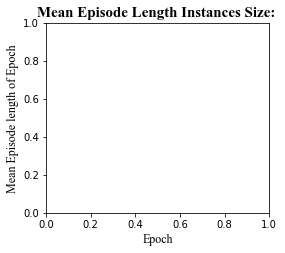

In [24]:
# investigate instance 5 and 8 for one env 100... on size 6
import pandas as pd
import ast
df=pd.read_csv('/Users/felix/sciebo/masterarbeit/progra/model-based_rl/best_checkpoints_tests_size6_inst_20_220_2sims_1_5puct.csv')
identifier='6x6_24_inst_one_env_100_32'
print(df[identifier][0])
actions=ast.literal_eval( df[identifier][2])

import numpy as np
#Users.felix.sciebo.masterarbeit.progra.model-based_rl.

from src.jss_lite.jss_lite import jss_lite
from wrapper.jssplight_wrapper import jssp_light_obs_wrapper_multi_instances
from wrapper.jssplight_wrapper import jssp_light_obs_wrapper_no_action_mask
import time
import os
from random import randrange
inst_num=str(24)
inst_s=str(6)

instance_load="/Users/felix/sciebo/masterarbeit/progra/model-based_rl/resources/jsp_instances/ima/"+inst_s+"x"+inst_s+"x"+inst_s+"/"+inst_s+"x"+inst_s+"_"+inst_num+"_inst.json"
env=jssp_light_obs_wrapper_multi_instances(instances_list=[instance_load],env_config="config")
state=env.get_state()
reward_list=[]
token=False
for a in actions:
    state, reward, done, info=env.step(a)  

print(done)
print(reward)
fig, ax = plt.subplots(figsize=(4,3.5))
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Mean Episode length of Epoch', fontdict=font)
plt.title(f"Mean Episode Length Instances Size: ", fontdict=font_2)
env.render(x_bar="Machine",y_bar="Job")

env.render(y_bar="Machine",x_bar="Job")

json_render(instance_load,x_bar="Machine",y_bar="Job")
json_render(instance_load,y_bar="Machine",x_bar="Job")

In [32]:
ids=['500_sims_multi_env', 'one_env_100', 'one_env_2000']
best={'6':['31', '32', '10'],'8': ['1', '69', '5'],'10': ['1', '47', '4'],'15': ['1', '55', '1']}
def get_model(iteration):
    return ids[iteration%3]
def get_iteration(iteration):
    size=[3,6,8,10,15]
    return size[int(math.floor(iteration/3))]
print(get_iteration(6))



8
